In [61]:
from library import *
from constant import *

In [6]:
repo_pd=pd.read_pickle('repo_case_study.pickle')
event_pd=pd.read_pickle('events_case_study.pickle')

In [7]:
len(event_pd), len(repo_pd)

(271399, 45)

<AxesSubplot:>

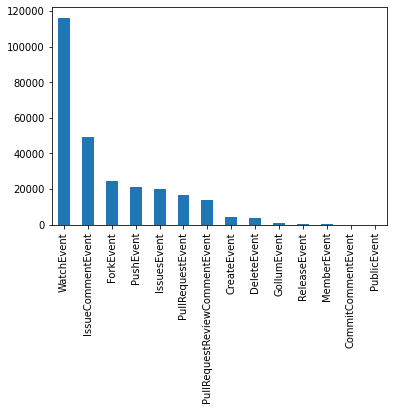

In [8]:
#event distribution
event_pd['event_type'].value_counts().plot(kind='bar')

### Feature Extraction

In [9]:
#repo created after 2017 (to get all its events)
repo_ids=set()
for row in repo_pd.iterrows():
    if row[1]['created_at'].split('-')[0] in {'2017', '2018', '2019', '2020'}:
        repo_ids.add(row[1]['repo_id'])

In [10]:
len(repo_ids)#41 repos created after 2017

41

In [11]:
frequent_repo=event_pd[event_pd.repo_id.isin(repo_ids)].repo_id.value_counts().head(30).to_dict()

In [12]:
len(frequent_repo)

30

In [13]:
#filter events created after 2017 + at least 500 events
event_pd=event_pd[event_pd.repo_id.isin(frequent_repo)]

In [14]:
len(event_pd)# 30 repos --> 235,446 events

235446

In [15]:
X=event_pd[event_pd.event_type!='WatchEvent'][['repo_id', 'event_type']].groupby('repo_id')['event_type'].apply(list)
repo_events=pd.DataFrame({'repo_id':X.index, 'events':X.values})

X=event_pd[event_pd.event_type=='WatchEvent'][['repo_id', 'actor_id']].groupby('repo_id')['actor_id'].apply(list)
repo_watcher=pd.DataFrame({'repo_id':X.index, 'actor_id':X.values})

X=event_pd[event_pd.event_type!='WatchEvent'][['repo_id', 'actor_id']].groupby('repo_id')['actor_id'].apply(list)
repo_contributor=pd.DataFrame({'repo_id':X.index, 'actor_id':X.values})


In [16]:
len(repo_contributor), len(repo_watcher), len(event_pd), len(repo_events)

(30, 30, 235446, 30)

#### percentage of events


In [17]:
repo_events_features=defaultdict()

for row in tqdm(repo_events.iterrows()):
    events_percentage={'PushEvent':0, 'ForkEvent':0, 'IssueCommentEvent':0, 'IssuesEvent':0, 'PullRequestEvent':0, 'CreateEvent':0,
  'PullRequestReviewCommentEvent':0, 'DeleteEvent':0, 'GollumEvent':0, 'MemberEvent':0, 'ReleaseEvent':0,
   'CommitCommentEvent':0, 'PublicEvent':0}

    a=dict(Counter(row[1]['events']))
    #normalization
    a = {k: v / len(row[1]['events']) for k, v in a.items()}
    for event in a:
        events_percentage[event]=a[event]
    repo_events_features[row[1]['repo_id']]=events_percentage

30it [00:00, 977.86it/s]


#### Jaccard 

In [18]:
#jaccard similarity between contributors and watchers
#merge repo_watcher and repo_contributor
repo_watcher_contributor=repo_contributor.merge(repo_watcher[['repo_id', 'actor_id']], left_on='repo_id', right_on='repo_id', how='left')
#rename columns
repo_watcher_contributor.rename(columns={'repo_id': 'repo_id', 'actor_id_x': 'contributor_id', 'actor_id_y':'watcher_id'}, inplace=True)


In [19]:
repo_watcher_contributor=repo_watcher_contributor[['repo_id', 'contributor_id', 'watcher_id']]

#replace nan with []
repo_watcher_contributor.loc[repo_watcher_contributor['watcher_id'].isnull(),['watcher_id']] = repo_watcher_contributor.loc[repo_watcher_contributor['watcher_id'].isnull(),'watcher_id'].apply(lambda watcher_id: [])

#calculate jaccard feature
repo_watcher_contributor['jaccard'] = repo_watcher_contributor.apply(lambda row: len(set(row.contributor_id).intersection(set(row.watcher_id)))/len(set(row.contributor_id).union(set(row.watcher_id))) , axis=1)


#### length of comments

In [20]:
commit_history=pd.read_pickle('commit_history_case_study.pickle')

In [21]:
X=commit_history[['repo_id', 'comment']].groupby('repo_id')['comment'].apply(list)
repo_commits=pd.DataFrame({'repo_id':X.index, 'comment':X.values})

In [22]:
med_comment_len=defaultdict()
mean_comment_len=defaultdict()

for row in repo_commits.iterrows():
    tmp=[]
    for comment in row[1]['comment']:
        try:
            tmp.append(len(comment.split()))
        except:
            tmp.append(0)
            
    med_comment_len[row[1]['repo_id']]=np.median(tmp)
    mean_comment_len[row[1]['repo_id']]=mean(tmp)

    

#### num leaders

In [23]:
#Distribution of number of unique users with pull request and push events (or non-watcher users)
repo_leaders=event_pd[(event_pd.event_type=='PushEvent') | (event_pd.event_type=='PullRequestEvent')][['repo_id', 'actor_id']].groupby('repo_id')['actor_id'].apply(list)
repo_leaders=pd.DataFrame({'repo_id':repo_leaders.index, 'actor_ids':repo_leaders.values})
repo_leaders['num_leaders'] = repo_leaders.apply(lambda row: len(set(row.actor_ids)), axis=1)
repo_leaders=repo_leaders.drop(['actor_ids'], axis=1)


## Sequence Learning

In [24]:
#convert "%Y-%m-%d-%H" to unix
event_pd['time_stamp'] = event_pd.apply(lambda row: datetime.strptime(row.file_date, "%Y-%m-%d-%H").timestamp(), axis=1)

In [25]:
#index as col
event_pd['index1'] = event_pd.index

In [26]:
#sort row by time_stamp and index (to keep the order of events occured within same hour)
event_pd=event_pd.sort_values(by=['time_stamp', 'index1'])

In [27]:
len(event_pd)

235446

In [28]:
event_pd_w_o_watch=event_pd[event_pd.event_type!='WatchEvent']#without watch for case-study

In [29]:
len(event_pd_w_o_watch)

124780

In [24]:
#event_pd.to_pickle('event_time_case_study.pickle')

In [25]:
#event_pd_w_o_watch.to_pickle('event_time_w_o_watch_case_study.pickle')

In [30]:
#group by repo-id
event_sequence=event_pd[['repo_id', 'event_type']].groupby('repo_id')['event_type'].apply(list)
event_sequence=pd.DataFrame({'repo_id':event_sequence.index, 'event_type':event_sequence.values})
#group by repo-id
time_sequence=event_pd[['repo_id', 'time_stamp']].groupby('repo_id')['time_stamp'].apply(list)
time_sequence=pd.DataFrame({'repo_id':time_sequence.index, 'time_stamp':time_sequence.values})

### IAT (inter arrival time)

In [31]:
repo_iat_mean, repo_iat_med={}, {} #with watch/ first 500 events 
for row in time_sequence.iterrows():
    time_stamps=row[1]['time_stamp']
    l=len(time_stamps)
    if l>500:
        time_stamps=time_stamps[:500]
        
    tmp=[]
    for i in range(1, len(time_stamps)):
        tmp.append((time_stamps[i]-time_stamps[i-1])/86400.0)#in day/in hour
    repo_iat_mean[row[1]['repo_id']]=mean(tmp)
    repo_iat_med[row[1]['repo_id']]=np.median(tmp)
        
        
        

In [32]:
repo_pd[repo_pd.repo_id.isin(frequent_repo)].owner_login.value_counts()

microsoft                    5
facebookresearch             5
google-research              5
NVIDIA                       5
Tencent                      4
baidu                        2
softbankrobotics-research    1
sony                         1
alibaba                      1
PaddlePaddle                 1
Name: owner_login, dtype: int64

In [33]:
event_pd.columns

Index(['event_id', 'event_type', 'repo_id', 'repo_name', 'actor_id',
       'file_date', 'time_stamp', 'index1'],
      dtype='object')

#### merge features into repo_features

In [34]:
#put all the features along with repo_id in one dataframe

In [35]:
repo_features=pd.DataFrame.from_dict(repo_events_features, orient='index')

In [36]:
repo_features['repo_id']=repo_features.index

In [37]:
repo_count_features=repo_pd[['repo_id', 'star_count', 'forks_count', 'open_issues_count']]

In [38]:
#merge repo_features and repo_count_features
repo_features=repo_features.merge(repo_count_features[['repo_id', 'star_count', 'forks_count', 'open_issues_count']], left_on='repo_id', right_on='repo_id', how='left')

In [39]:
#merge repo_features and jaccard
repo_features=repo_features.merge(repo_watcher_contributor[['repo_id', 'jaccard']], left_on='repo_id', right_on='repo_id', how='left')


In [40]:
#merge repo_features and comment len (average)
CommentLen=[]
for row in repo_features.iterrows():
    CommentLen.append(mean_comment_len[(int(row[1]['repo_id']))])    

In [41]:
repo_features['CommentLen']=CommentLen

In [42]:
#merge repo_features and iat (median)
iat=[]
for row in repo_features.iterrows():
    iat.append(repo_iat_med[row[1]['repo_id']])

In [43]:
repo_features['iat']=iat

In [44]:
#merge repo_features and repo_leader
repo_features=repo_features.merge(repo_leaders[['repo_id', 'num_leaders']], left_on='repo_id', right_on='repo_id', how='left')


In [45]:
#fill nan for num_leaders with zeros
repo_features['num_leaders'] = repo_features['num_leaders'].fillna(0)

In [46]:
repo_sequence=pd.read_pickle('latent_vectors_case_study.pickle')#w/o watch

In [47]:
repo_features=repo_features.merge(repo_sequence, left_on='repo_id', right_on='repo_id', how='left')

In [ ]:
# repo_features=repo_features.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
#                   31,32,33,34,35,36,37,38,39], axis = 1)

In [51]:
repo_features.shape

(30, 65)

#### normalization of 'star_count', 'forks_count', 'open_issues_count', 'CommentLen', 'num_leaders'

In [49]:
repo_features['star_count_normal']=np.log(repo_features['star_count']+1)
repo_features['forks_count_normal']=np.log(repo_features['forks_count']+1)
repo_features['open_issues_count_normal']=np.log(repo_features['open_issues_count']+1)
repo_features['num_leaders_normal']=np.log(repo_features['num_leaders']+1)

### KNN

In [52]:
#repo_pd[['repo_id', 'owner_login']].drop_duplicates #label --> owner_login
repo_features=repo_features.merge(repo_pd[['repo_id', 'owner_login', 'repo_name']], left_on='repo_id', right_on='repo_id', how='left')


In [53]:
repo_features.shape

(30, 67)

In [54]:
#map paddlepaddle to baidu
repo_features['owner_login'].replace({'PaddlePaddle': 'baidu'}, inplace=True)


In [55]:
X_emb=list(range(40))
X_profile=['forks_count_normal','star_count_normal','open_issues_count_normal','num_leaders_normal','CommentLen','jaccard','iat']
X_act=['PushEvent','ForkEvent','IssueCommentEvent','IssuesEvent','PullRequestEvent','CreateEvent',
       'PullRequestReviewCommentEvent','DeleteEvent','GollumEvent','MemberEvent','ReleaseEvent','CommitCommentEvent',
       'PublicEvent']


In [56]:
repo_features=repo_features[repo_features.owner_login.isin({'microsoft', 'facebookresearch', 'NVIDIA', 'google-research', 'Tencent', 'baidu'})]

In [57]:
repo_features.owner_login.value_counts()

microsoft           5
facebookresearch    5
google-research     5
NVIDIA              5
Tencent             4
baidu               3
Name: owner_login, dtype: int64

#### Predicting labels

In [106]:
for row in repo_features.iterrows():
   
    X=repo_features[repo_features.repo_id!=row[1]['repo_id']]
    y=X.owner_login
    
    
    query=repo_features[repo_features.repo_id==row[1]['repo_id']]
    
    print ('Actual Label:   ', query.owner_login.values[0])
    print ('Project Name:   ', query.repo_name.values[0])
    
    features=X_profile+X_emb+X_act
    X=X[features]
    query=query[features]
    

    
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X, y)
    
    print ('Predicted Label:', neigh.predict(query)[0])
   

    print ()
    

Actual Label:    facebookresearch
Project Name:    ParlAI
Predicted Label: facebookresearch

Actual Label:    facebookresearch
Project Name:    ReAgent
Predicted Label: facebookresearch

Actual Label:    microsoft
Project Name:    MMdnn
Predicted Label: facebookresearch

Actual Label:    NVIDIA
Project Name:    pix2pixHD
Predicted Label: microsoft

Actual Label:    NVIDIA
Project Name:    FastPhotoStyle
Predicted Label: Tencent

Actual Label:    NVIDIA
Project Name:    apex
Predicted Label: NVIDIA

Actual Label:    microsoft
Project Name:    nni
Predicted Label: facebookresearch

Actual Label:    baidu
Project Name:    Senta
Predicted Label: Tencent

Actual Label:    facebookresearch
Project Name:    pytext
Predicted Label: facebookresearch

Actual Label:    microsoft
Project Name:    human-pose-estimation.pytorch
Predicted Label: NVIDIA

Actual Label:    baidu
Project Name:    Dialogue
Predicted Label: baidu

Actual Label:    Tencent
Project Name:    Metis
Predicted Label: NVIDIA

Act

In [111]:
X=repo_features.drop(['num_leaders', 'forks_count', 'star_count', 'open_issues_count', 'repo_id'], axis=1)

In [112]:
X.shape, repo_features.shape

((27, 62), (27, 67))

In [452]:
#X.to_pickle('case_study_feature_representation.pickle')

In [295]:
#X=pd.read_pickle('case_study_feature_representation.pickle')

#### Visulalization (PCA)

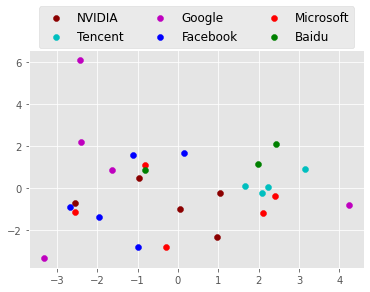

In [114]:
from IPython.display import display


pd.options.display.max_columns = None
plt.style.use('ggplot')

mtx=X

companies = list(mtx['owner_login'])
#companies=list(mtx['repo_name'])

mtx = mtx.drop(['owner_login'], axis=1)
mtx = mtx.drop(['repo_name'], axis=1)



companiescolors = {
    'facebookresearch': 'b',
    'microsoft': 'r',
    'NVIDIA': 'darkred',
    'baidu': 'g',
    'Tencent': 'c',
    'google-research': 'm'
}


companieslegends = {
    'facebookresearch': 'Facebook',
    'microsoft': 'Microsoft',
    'NVIDIA': 'NVIDIA',
    'baidu': 'Baidu',
    'Tencent': 'Tencent',
    'google-research': 'Google'
}

# companiescolors = {
#  'ParlAI': 'black',
#  'ReAgent': 'gray',
#  'MMdnn': 'silver',
#  'pix2pixHD': 'whitesmoke',
#  'FastPhotoStyle': 'rosybrown',
#  'apex': 'firebrick',
#  'nni': 'red',
#  'Senta': 'darksalmon',
#  'pytext': 'sienna',
#  'human-pose-estimation.pytorch': 'sandybrown',
#  'Dialogue': 'tan',
#  'Metis': 'gold',
#  'bert': 'darkkhaki',
#  'waveglow': 'palegreen',
#  'FaceDetection-DSFD': 'darkgreen',
#  'ObjectDetection-OneStageDet': 'darkcyan',
#  'PaddleHub': 'navy',
#  'pyrobot': 'blue',
#  'tensor2robot': 'mediumpurple',
#  'uda': 'darkorchid',
#  'NeuralNLP-NeuralClassifier': 'teal',
#  'unilm': 'plum',
#  'NeMo': 'pink',
#  'detectron2': 'orange',
#  'text-to-text-transfer-transformer': 'darkred',
#  'albert': 'crimson',
#  'DeepSpeed': 'brown'
# }


# companieslegends = {
#  'ParlAI': 'ParlAI',
#  'ReAgent': 'ReAgent',
#  'MMdnn': 'MMdnn',
#  'pix2pixHD': 'pix2pixHD',
#  'FastPhotoStyle': 'FastPhotoStyle',
#  'apex': 'apex',
#  'nni': 'nni',
#  'Senta': 'Senta',
#  'pytext': 'pytext',
#  'human-pose-estimation.pytorch': 'human-pose',
#  'Dialogue': 'Dialogue',
#  'Metis': 'Metis',
#  'bert': 'BERT',
#  'waveglow': 'waveglow',
#  'FaceDetection-DSFD': 'DSFD',
#  'ObjectDetection-OneStageDet': 'OneStageDe',
#  'PaddleHub': 'PaddleHub',
#  'pyrobot': 'pyrobot',
#  'tensor2robot': 'tens2robot',
#  'uda': 'uda',
#  'NeuralNLP-NeuralClassifier': 'NNLP',
#  'unilm': 'unilm',
#  'NeMo': 'NeMo',
#  'detectron2': 'detectron2',
#  'text-to-text-transfer-transformer': 'tx2txTransfer',
#  'albert': 'albert',
#  'DeepSpeed': 'DeepSpeed'
# }



c = [companiescolors[i] for i in companies]
t = PCA(n_components=2)
x = t.fit_transform(mtx)
for company in (set(companies)):
    idxes = [i for i, j in enumerate(companies) if j == company]
    v = x[idxes, :]
    plt.scatter(v[:, 0], v[:, 1], c=companiescolors[company], label=companieslegends[company])
    #plt.annotate(companieslegends[company], (list(x[idxes[0]])[0], list(x[idxes[0]])[1]))
plt.legend(bbox_to_anchor=(0.99, 1.23), ncol=3, fontsize=12)
#plt.xticks([])
#plt.yticks([])
plt.savefig('Plots/case_study_pca.pdf', bbox_inches='tight')

In [107]:
#distribution of events across repos (focus on repos with at least 500 events)
event_pd.repo_name.value_counts()

google-research/bert                                 35265
facebookresearch/ParlAI                              33668
facebookresearch/detectron2                          23465
microsoft/nni                                        15874
NVIDIA/FastPhotoStyle                                12257
facebookresearch/pytext                              11840
NVIDIA/apex                                          10269
NVIDIA/NeMo                                          10258
Microsoft/nni                                         7931
Microsoft/MMdnn                                       7382
PaddlePaddle/PaddleHub                                6573
NVIDIA/pix2pixHD                                      6496
sony/nnabla                                           6477
google-research/text-to-text-transfer-transformer     5140
microsoft/DeepSpeed                                   4551
NVIDIA/waveglow                                       3267
TencentYoutuResearch/FaceDetection-DSFD               31

In [108]:
#Done !